## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [9]:
import os
import keras
import tensorflow as tf
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

config = tf.ConfigProto(allow_soft_placement=True)

#最多占gpu资源的70%
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.7)

#开始不会给tensorflow全部gpu资源 而是按需增加
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5,0.7]
redice_lr_patient = [5,7]

In [10]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
#    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 2s 49us/step - loss: 1.3664 - acc: 0.5261 - val_loss: 1.5297 - val_acc: 0.4685
Epoch 14/25
50000/50000 [==============================] - 2s 50us/step - loss: 1.3463 - acc: 0.5347 - val_loss: 1.5235 - val_acc: 0.4673
Epoch 15/25
50000/50000 [==============================] - 2s 50us/step - loss: 1.3284 - acc: 0.5391 - val_loss: 1.5163 - val_acc: 0.4727
Epoch 16/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.3108 - acc: 0.5481 - val_loss: 1.5086 - val_acc: 0.4775
Epoch 17/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.2926 - acc: 0.5538 - val_loss: 1.5033 - val_acc: 0.4764
Epoch 18/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.2766 - acc: 0.5599 - val_loss: 1.4967 - val_acc: 0.4800
Epoch 19/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.2592 - acc: 0.5648 - val_loss: 1.4959 - val_acc: 0.4766
Epoch 20/25
50000/50000 [=====================

50000/50000 [==============================] - 4s 80us/step - loss: 2.3101 - acc: 0.2433 - val_loss: 2.2029 - val_acc: 0.2895
Epoch 2/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.8674 - acc: 0.3567 - val_loss: 1.9158 - val_acc: 0.3580
Epoch 3/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.7349 - acc: 0.3991 - val_loss: 1.7825 - val_acc: 0.3844
Epoch 4/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.6595 - acc: 0.4230 - val_loss: 1.7237 - val_acc: 0.3995
Epoch 5/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.6063 - acc: 0.4397 - val_loss: 1.6712 - val_acc: 0.4202
Epoch 6/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.5635 - acc: 0.4560 - val_loss: 1.6499 - val_acc: 0.4213
Epoch 7/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.5281 - acc: 0.4659 - val_loss: 1.6236 - val_acc: 0.4314
Epoch 8/25
50000/50000 [============================

50000/50000 [==============================] - 3s 53us/step - loss: 0.4466 - acc: 0.8694 - val_loss: 1.5721 - val_acc: 0.5115
Epoch 24/25
50000/50000 [==============================] - 3s 52us/step - loss: 0.4259 - acc: 0.8802 - val_loss: 1.5460 - val_acc: 0.5224
Epoch 25/25
50000/50000 [==============================] - 3s 54us/step - loss: 0.4105 - acc: 0.8856 - val_loss: 1.5805 - val_acc: 0.5188
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 7
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_19 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer

50000/50000 [==============================] - 3s 53us/step - loss: 1.1126 - acc: 0.6213 - val_loss: 1.5278 - val_acc: 0.4794loss: 1.1057 
Epoch 11/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.0812 - acc: 0.6318 - val_loss: 1.4447 - val_acc: 0.4896
Epoch 12/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.0521 - acc: 0.6434 - val_loss: 1.4987 - val_acc: 0.4834
Epoch 13/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.0270 - acc: 0.6547 - val_loss: 1.4183 - val_acc: 0.5008
Epoch 14/25
50000/50000 [==============================] - 3s 51us/step - loss: 0.9996 - acc: 0.6647 - val_loss: 1.4685 - val_acc: 0.4940
Epoch 15/25
50000/50000 [==============================] - 3s 51us/step - loss: 0.9760 - acc: 0.6725 - val_loss: 1.4242 - val_acc: 0.5044
Epoch 16/25
50000/50000 [==============================] - 3s 51us/step - loss: 0.9500 - acc: 0.6848 - val_loss: 1.4692 - val_acc: 0.4980
Epoch 17/25
50000/50000 [========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 97us/step - loss: 1.8207 - acc: 0.3692 - val_loss: 2.1271 - val_acc: 0.2947
Epoch 2/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.5397 - acc: 0.4567 - val_loss: 6.6769 - val_acc: 0.1553
Epoch 3/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.4333 - acc: 0.4931 - val_loss: 2.1983 - val_acc: 0.2981
Epoch 4/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.3520 - acc: 0.5237 - val_loss: 2.3869 - val_acc: 0.2732
Epoch 5/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.2983 - acc: 0.5393 - val_loss: 1.9020 - val_acc: 0.3145
Epoch 6/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.2484 - acc: 0.5591 - val_loss: 2.0610 - val_acc: 0.3189
Epoch 7/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.2015 - acc: 0.5776 - val_loss: 2.1658 - val_acc

Epoch 22/25
50000/50000 [==============================] - 5s 90us/step - loss: 0.7410 - acc: 0.7664 - val_loss: 1.4934 - val_acc: 0.4898
Epoch 23/25
50000/50000 [==============================] - 6s 113us/step - loss: 0.7228 - acc: 0.7740 - val_loss: 1.4911 - val_acc: 0.4909
Epoch 24/25
50000/50000 [==============================] - 5s 91us/step - loss: 0.7075 - acc: 0.7775 - val_loss: 1.4903 - val_acc: 0.4970
Epoch 25/25
50000/50000 [==============================] - 3s 70us/step - loss: 0.6900 - acc: 0.7854 - val_loss: 1.5837 - val_acc: 0.4692
Numbers of exp: 10, reduce_factor: 0.70, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
__________________________________________________________

50000/50000 [==============================] - 3s 55us/step - loss: 1.3668 - acc: 0.5256 - val_loss: 1.6118 - val_acc: 0.4361
Epoch 9/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.3325 - acc: 0.5378 - val_loss: 1.5738 - val_acc: 0.4489
Epoch 10/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.3007 - acc: 0.5482 - val_loss: 1.5607 - val_acc: 0.4547
Epoch 11/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.2698 - acc: 0.5596 - val_loss: 1.5369 - val_acc: 0.4643
Epoch 12/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.2419 - acc: 0.5727 - val_loss: 1.5261 - val_acc: 0.4614
Epoch 13/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.2156 - acc: 0.5826 - val_loss: 1.5155 - val_acc: 0.4691oss: 1.2156 - acc: 0.582
Epoch 14/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.1901 - acc: 0.5910 - val_loss: 1.5053 - val_acc: 0.4754
Epoch 15/25
50000/50000

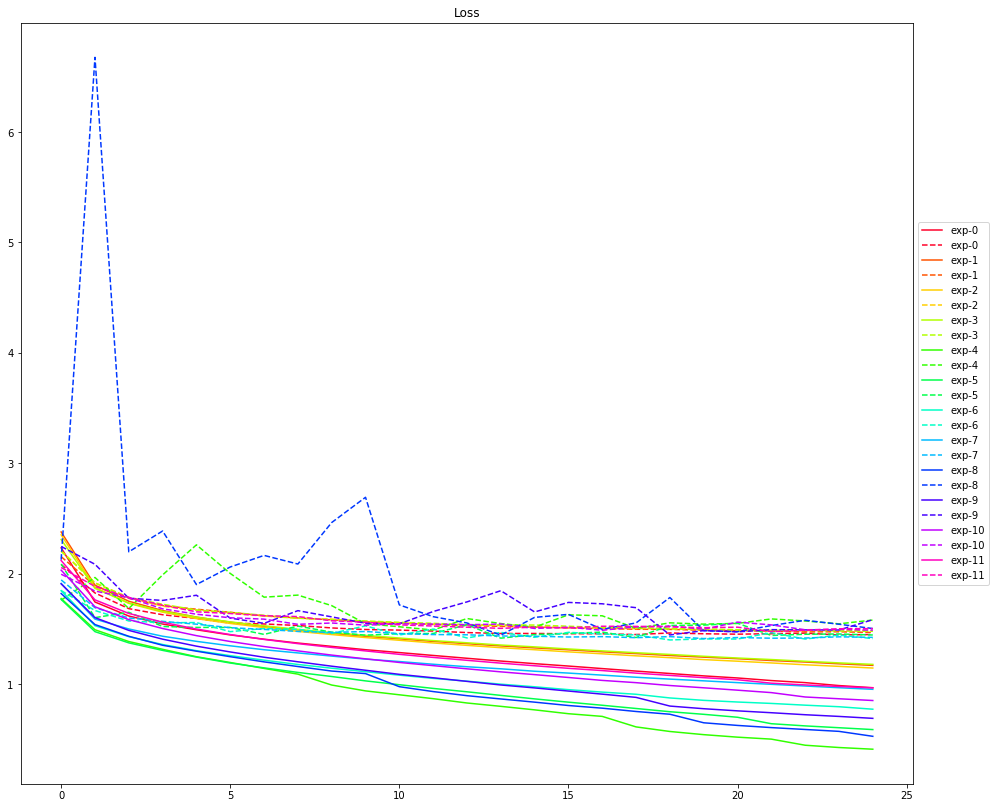

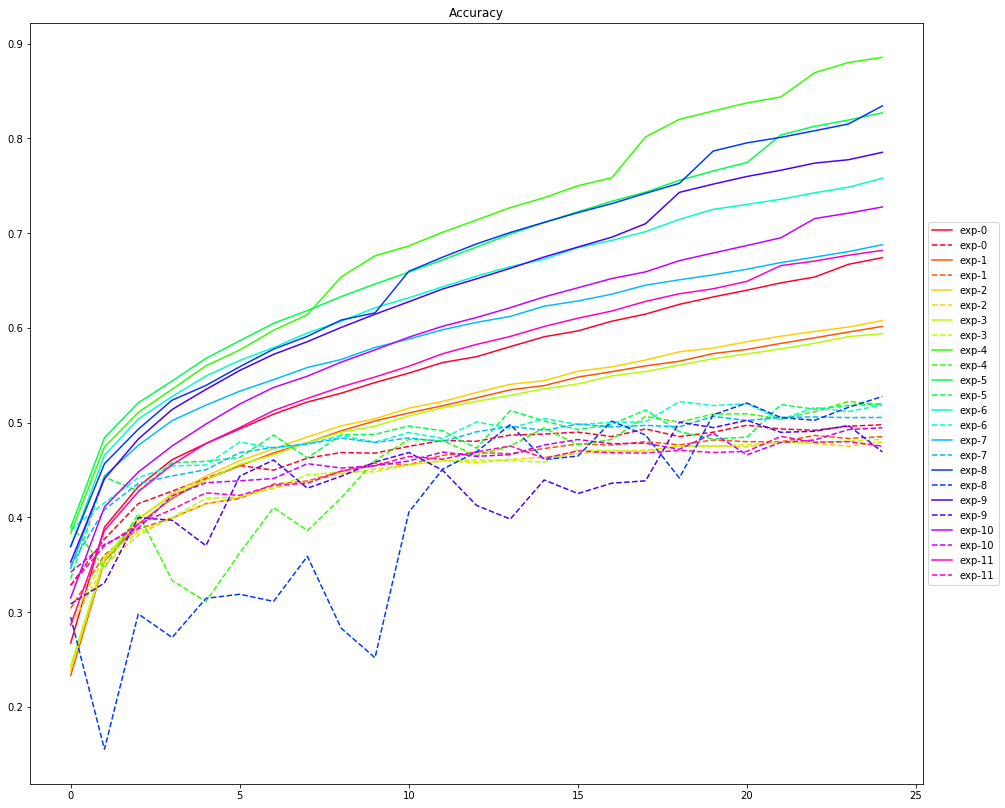

In [12]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(16,14))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(16,14))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()